In this notebook we have combined the digester's dataset with the first release of the Earth Microbiome Project (150 nucleotides). We'll classify samples for each day according to the different levels of the EMP ontology.

In specific we have to combine the two tables and representative sequences. Then we rarefy at the same level and create an insertion tree based on the combined sequences. Finally we generate UniFrac distance matrices and perform the k nearest neighbors classification.

In [1]:
cd trimmed-150nts/

/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/HastyWater/trimmed-150nts


In [3]:
%matplotlib inline
import qiime2 as q2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

from qiime2.plugins import emperor
from skbio import DistanceMatrix

sns.set_style('whitegrid')
sns.set_context('poster')

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

# Fetch the data

Get the processed data from barnacle. While there is more data than what we download, the distance matrices are the only thing we need. For details on how these matrices were generated look at the provenance of the artifacts or at the file located at `barnacle.ucsd.edu:/home/yovazquezbaeza/research/hasty-water/trimmed-150nts/emp-metaanalysis/commands.sh`.

In [ ]:
mkdir -p emp-metaanalysis

In [16]:
!scp barnacle:/home/yovazquezbaeza/research/hasty-water/trimmed-150nts/emp-metaanalysis/unweighted-unifrac.qza emp-metaanalysis/
!scp barnacle:/home/yovazquezbaeza/research/hasty-water/trimmed-150nts/emp-metaanalysis/weighted-unifrac.2.qza emp-metaanalysis/

!scp barnacle:/home/yovazquezbaeza/research/hasty-water/trimmed-150nts/emp-metaanalysis/pcoa.weighted-unifrac.2.qza emp-metaanalysis/

unweighted-unifrac.qza                        100% 1277MB  14.5MB/s   01:28    
weighted-unifrac.2.qza                        100% 1305MB  14.2MB/s   01:32    
pcoa.weighted-unifrac.2.qza                   100%  722MB  15.3MB/s   00:47    


In [ ]:
!scp barnacle:/projects/emp/00-qiime-maps/merged/emp_qiime_mapping_release1.tsv emp-metaanalysis/

# Load the distance matrix and mapping file

QIIME2 does not include a way to merge two mapping files, so do this by hand.

We save the mapping file for convenience.

In [4]:
a = load_mf('mapping-file.alpha.tsv')
b = load_mf('emp-metaanalysis/emp_qiime_mapping_release1.tsv')

mf = pd.concat([a, b]).fillna('no_data')

mf['trajectories'] = mf.apply(lambda row: 'no_data' if row.emp_release1 == 'True' else row.Description, axis=1)

mf.to_csv('emp-metaanalysis/combined-mappingfile.tsv', sep='\t')

The day category needs to be represented as a number so we can properly sort the samples.

In [5]:
mf['day'] = pd.to_numeric(mf.day, errors='coerce')

Load the distance matrix as a data frame.

In [6]:
dm = q2.Artifact.load('emp-metaanalysis/weighted-unifrac.2.qza').view(DistanceMatrix).to_data_frame()

Remove all the samples in the mapping file that are not represented by the distance matrix.

In [7]:
mf = mf.loc[dm.index].copy()

# Nearest neighbor classification

While this could be done more efficiently (using a dedicated data structure) our data sizes are small enough that it is a sufficiently fast solution for 10K samples.

In [13]:
wastewater_samples = set(mf[mf.emp_release1 == 'no_data'].index)
rows = []

for level in ['empo_1', 'empo_2', 'empo_3']:
    # ignore the samples at day zero since those are *controls*
    for day in np.arange(1, 30):

        for digester in ['Digester1', 'Digester2', 'Digester3', 'Digester4']:

            # the sample of interest for a digester at a given day
            sample = mf[((mf.Description == digester) & (mf.day == day))].index[0]

            distances = dm[sample].copy()
            distances = distances[~(distances.index.isin(wastewater_samples))]
            distances.sort_values(ascending=True, inplace=True)

            ids = distances[:200].index

            # series of "probabilities"
            sample_predictions = mf.loc[ids][level].value_counts(normalize=True)

            for prediction, probability in sample_predictions.items():
                rows.append([day, probability, prediction, level]) 

predictions = pd.DataFrame(columns=['Day', 'Prediction Probability', 'Predicted Label', 'Ontology Level'], data=rows)

Color the predictions according to the official EMP coloring scheme.

In [14]:
EMP_palette = {'EMP sample': '#929591', 'Host-associated': '#fb9a99', 'Free-living': '#e31a1c',
               'Animal': '#b2df8a', 'Plant': '#33a02c', 'Non-saline': '#a6cee3', 'Saline': '#1f78b4',
               'Aerosol (non-saline)': '#d3d3d3', 'Animal corpus': '#ffff00', 'Animal distal gut': '#8b4513',
               'Animal proximal gut': '#d2b48c', 'Animal secretion': '#f4a460', 'Animal surface': '#b8860b',
               'Hypersaline (saline)': '#87cefa', 'Intertidal (saline)': '#afeeee', 'Mock community': '#ff00ff',
               'Plant corpus': '#7cfc00', 'Plant rhizosphere': '#006400', 'Plant surface': '#00fa9a',
               'Sediment (non-saline)': '#ffa07a', 'Sediment (saline)': '#ff6347', 'Soil (non-saline)': '#ff0000',
               'Sterile water blank': '#ee82ee', 'Surface (non-saline)': '#000000', 'Surface (saline)': '#696969',
               'Water (non-saline)': '#000080', 'Water (saline)': '#4169e1'}

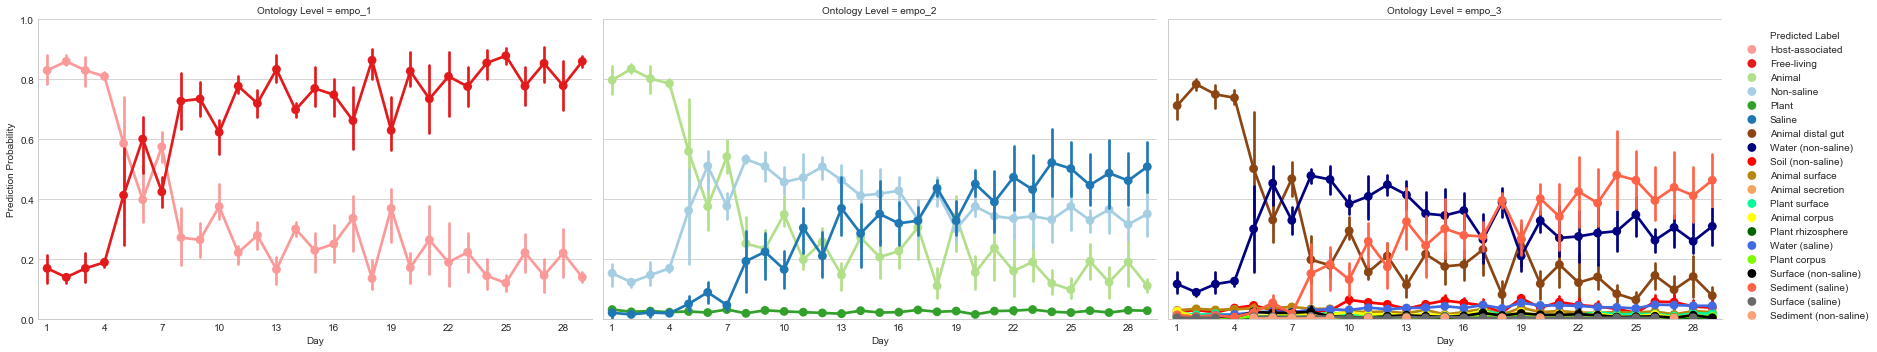

In [15]:
g = sns.factorplot(x='Day', y='Prediction Probability', hue='Predicted Label',
                   col='Ontology Level', data=predictions,
                   palette=EMP_palette, size=5, aspect=1.6180)

g.set(ylim=[0, 1])
g.set_xticklabels(step=3)
g.despine()

g.savefig('emp-metaanalysis/classification.pdf')

# Accompanying PCoA plot

In [22]:
res = emperor.visualizers.plot(
    pcoa=q2.Artifact.load('emp-metaanalysis/pcoa.weighted-unifrac.2.qza'),
    metadata=q2.Metadata.load('emp-metaanalysis/combined-mappingfile.tsv')
)

In [24]:
res.visualization.save('emp-metaanalysis/weighted-unifrac.qzv')

'emp-metaanalysis/weighted-unifrac.qzv'